numpy ver.: 1.19.1
pandas ver.: 1.1.2
tensorflow ver.: 2.1.0
keras ver.: 2.3.1


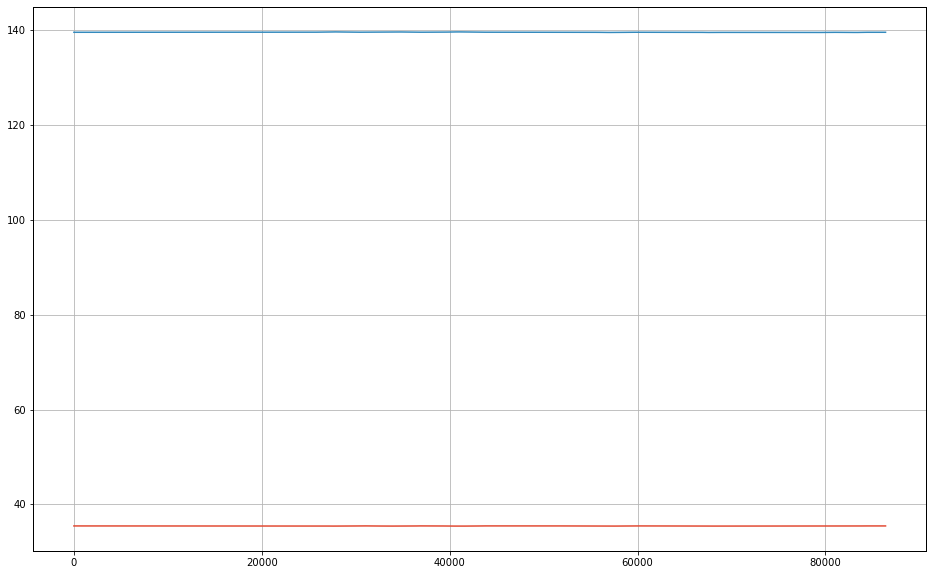

         lat         lng
0  35.456029  139.611249
1  35.456029  139.611249
2  35.456029  139.611249
3  35.456029  139.611249
4  35.456029  139.611249


In [33]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
import keras

from keras.models import Sequential
from keras.layers import *
from keras.layers.wrappers import *
from keras.optimizers import RMSprop
from keras.callbacks import CSVLogger, EarlyStopping
import keras.backend.tensorflow_backend as ktf

plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['axes.facecolor'] = 'w'
plt.rcParams['axes.labelcolor'] = 'k'
plt.rcParams['axes.edgecolor'] = 'k'
plt.rcParams['ytick.color'] = 'k'
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['grid.color'] = (.7, .7, .7, 0)
plt.rcParams['figure.figsize'] = (16, 10)

print('numpy ver.: ' + numpy.__version__)
print('pandas ver.: ' + pandas.__version__)
print('tensorflow ver.: ' + tf.__version__) 
print('keras ver.: ' + keras.__version__)
#データ読み込み
dataframe = pandas.read_csv('C:/Users/Hailin/OneDrive/ドキュメント/熊大関連/尼崎研/EV-Bus/evBus-main/evBus-main/1589.csv', usecols=[1,2], engine='python', skipfooter=1)
plt.plot(dataframe)
plt.show()
print(dataframe.head())

In [34]:
dataset = dataframe.values
dataset = dataset.astype('float32')
print(len(dataset))
dataset_real = dataset[24270:]
print(len(dataset))
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_real = scaler.fit_transform(dataset_real)

# split into train and test sets
train_size = int(len(dataset_real) * 0.67)
test_size = len(dataset_real) - train_size
train, test = dataset_real[0:train_size,:], dataset_real[train_size:len(dataset_real),:]
print(len(train), len(test))

86399
86399
41626 20503


In [35]:
print(train.shape)
print(train[0])

(41626, 2)
[0.77734375 0.3031006 ]


In [36]:
# convert an array of values into a dataset matrix
# if you give look_back 3, a part of the array will be like this: Jan, Feb, Mar
def create_dataset(dataset, look_back=1, look_forward=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-look_forward-1):
        xset, yset = [], []
        for j in range(dataset.shape[1]):
            a = dataset[i:(i+look_back), j]
            b = dataset[(i+look_back):(look_forward+look_back+i), j]
            xset.append(a)
            yset.append(b)
        dataX.append(xset)
        dataY.append(yset)
    return numpy.array(dataX), numpy.array(dataY)

# use 60 --> predict 15
look_back = 60
look_forward = 15

trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)
print(trainX.shape)
print(trainX[7001])

print(trainY.shape)
print(trainY[7000])

(41550, 2, 60)
[[0.8045044  0.80303955 0.80163574 0.8001709  0.79870605 0.7972412
  0.79577637 0.79437256 0.7929077  0.7915039  0.789917   0.78845215
  0.7869873  0.7855835  0.7843628  0.78338623 0.7822876  0.7810669
  0.77978516 0.77856445 0.7774658  0.7764282  0.7751465  0.77368164
  0.7720947  0.7706299  0.76916504 0.76763916 0.7661743  0.7645874
  0.76312256 0.7617798  0.760437   0.7593384  0.7585449  0.7578125
  0.7575073  0.75738525 0.75738525 0.75738525 0.75738525 0.75738525
  0.75738525 0.75738525 0.75738525 0.75738525 0.75738525 0.7573242
  0.75701904 0.7565918  0.7559204  0.755188   0.75439453 0.75354004
  0.7526245  0.7515259  0.7501831  0.74890137 0.7474365  0.7459717 ]
 [0.44555664 0.44543457 0.4453125  0.44506836 0.4449463  0.44482422
  0.44458008 0.44433594 0.44421387 0.44396973 0.4437256  0.44348145
  0.44299316 0.44274902 0.4423828  0.44213867 0.44177246 0.4416504
  0.44189453 0.44250488 0.44274902 0.44299316 0.44348145 0.44384766
  0.44433594 0.44482422 0.44519043 0.4

In [38]:
trainX_trans = trainX.transpose((0, 2, 1))
trainY_trans = trainY.transpose((0, 2, 1))
testX_trans = testX.transpose((0, 2, 1))
testY_trans = testY.transpose((0, 2, 1))

(41550, 60, 2)
(41550, 15, 2)
(20427, 60, 2)
(20427, 15, 2)


In [40]:
trainX_re = trainX_trans.reshape((trainX_trans.shape[0], 60, 1, trainX_trans.shape[2], 1))
trainY_re = trainY_trans.reshape((trainY_trans.shape[0], 15, 1, trainY_trans.shape[2], 1))
testX_re = testX_trans.reshape((testX_trans.shape[0], 60, 1, testX_trans.shape[2], 1))
testY_re = testY_trans.reshape((testY_trans.shape[0], 15, 1, testY_trans.shape[2], 1))

print(trainX_re.shape)
print(trainY_re.shape)
print(testX_re.shape)
print(testY_re.shape)

(41550, 60, 1, 2, 1)
(41550, 15, 1, 2, 1)
(20427, 60, 1, 2, 1)
(20427, 15, 1, 2, 1)


In [48]:
# create ConvLSTM
n_timesteps = trainX_re.shape[1]
output_timesteps = 15
model = Sequential()
model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (n_timesteps, trainX_re.shape[2], trainX_re.shape[3], 1)))
model.add(ConvLSTM2D(name ='conv_lstm_1',
                     filters = 64, kernel_size = (10, 1),                       
                     padding = 'same', 
                     return_sequences = True))
    
model.add(Dropout(0.21, name = 'dropout_1'))
model.add(BatchNormalization(name = 'batch_norm_1'))

model.add(ConvLSTM2D(name ='conv_lstm_2',
                     filters = 64, kernel_size = (5, 1), 
                     padding='same',
                     return_sequences = False))
    
model.add(Dropout(0.20, name = 'dropout_2'))
model.add(BatchNormalization(name = 'batch_norm_2'))
    
model.add(Flatten())
model.add(RepeatVector(output_timesteps))
model.add(Reshape((output_timesteps, 1, 2, 64)))

model.add(ConvLSTM2D(name ='conv_lstm_3',
                     filters = 64, kernel_size = (10, 1), 
                     padding='same',
                     return_sequences = True))
    
model.add(Dropout(0.1, name = 'dropout_3'))
model.add(BatchNormalization(name = 'batch_norm_3'))
    
model.add(ConvLSTM2D(name ='conv_lstm_4',
                     filters = 64, kernel_size = (5, 1), 
                     padding='same',
                     return_sequences = True))
    
model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
#model.add(Dense(units=1, name = 'dense_2'))

#optimizer = RMSprop() #lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.9)
#model.compile(loss = "mse", optimizer = optimizer)
model.summary()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mape'])
model.fit(trainX_re, trainY_re, epochs=70, batch_size=16)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_norm_0 (BatchNormaliza (None, 60, 1, 2, 1)       4         
_________________________________________________________________
conv_lstm_1 (ConvLSTM2D)     (None, 60, 1, 2, 64)      166656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 1, 2, 64)      0         
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 60, 1, 2, 64)      256       
_________________________________________________________________
conv_lstm_2 (ConvLSTM2D)     (None, 1, 2, 64)          164096    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 2, 64)          0         
_________________________________________________________________
batch_norm_2 (BatchNormaliza (None, 1, 2, 64)         

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node conv_lstm_1_4/convolution (defined at F:\program\miniconda3\envs\ohm379\lib\site-packages\keras\backend\tensorflow_backend.py:3009) ]] [Op:__inference_keras_scratch_graph_16537]

Function call stack:
keras_scratch_graph


In [5]:
loaded_model = tf.keras.models.load_model('C:/Users/Hailin/OneDrive/ドキュメント/熊大関連/尼崎研/EV-Bus/evBus-main/evBus-main/ConvLSTM_train60.h5')

loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_norm_0 (BatchNormaliza (None, 3, 10, 2, 1)       4         
_________________________________________________________________
conv_lstm_1 (ConvLSTM2D)     (None, 3, 10, 2, 64)      166656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 10, 2, 64)      0         
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 3, 10, 2, 64)      256       
_________________________________________________________________
conv_lstm_2 (ConvLSTM2D)     (None, 10, 2, 64)         164096    
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 2, 64)         0         
_________________________________________________________________
batch_norm_2 (BatchNormaliza (None, 10, 2, 64)         2

In [6]:
print(testX.shape)
print(testY.shape)

(28481, 3, 10, 2, 1)
(28481, 1, 1, 2, 1)


In [11]:
print(testX[1])
print(testY[0])

[[0.18536377 0.18566895]
 [0.18591309 0.18603516]
 [0.18609619 0.18603516]
 [0.18603516 0.18603516]
 [0.18603516 0.18603516]
 [0.18603516 0.18603516]
 [0.18603516 0.18603516]
 [0.18603516 0.18603516]
 [0.18603516 0.18609619]
 [0.18621826 0.1862793 ]
 [0.1864624  0.18682861]
 [0.18719482 0.18756104]
 [0.18804932 0.18859863]
 [0.18933105 0.19006348]
 [0.19091797 0.19189453]
 [0.07702637 0.07739258]
 [0.07751465 0.07763672]
 [0.07763672 0.07763672]
 [0.07763672 0.07763672]
 [0.07763672 0.07763672]
 [0.07763672 0.07763672]
 [0.07763672 0.07763672]
 [0.07763672 0.07763672]
 [0.07763672 0.07775879]
 [0.07775879 0.07788086]
 [0.07800293 0.07824707]
 [0.07861328 0.07885742]
 [0.07922363 0.07958984]
 [0.08007812 0.08044434]
 [0.08068848 0.08117676]]
[[0.19189453 0.08117676]]
